<a href="https://colab.research.google.com/github/Rain1618/Global-Health-Hack/blob/main/Copy_of_YOLOv8_Pipeline_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Main task:** train front cam with real life images to identify the following classes:

 ["Abydos Symbol", "Buoy", "Earth Symbol", "Gate", "Lane Marker", "Octagon Table"]

** Secondary task:** train different model for the down cam to identify the following classes:
  ["Lane Marker", "Octagon Table"],

  Should output a .py model file at the end.

TODO:

*   Avoid sample_data getting downloaded when we import the YOLO model
*   Automate uploading data and changing name and directory
*   Make the data.yaml adapt to the classes of the dataset
*   Make shuffle function get a similar similar sample size of images for every class in the train, test and val splits. Split by class and then combine together to make sure the datasets are balanced
*   In "Front cam" (176 images) there's goofy images of buoy where the buoy is not in water (sort by updated)
*   Do some sort of data parallelism, model parallelism, and pipeline parallelism to speed up training time?



#Questions

*  image filtering techniques to increase the quality of the footage?

**Duke dataset**
*    "pool..." = real image
*    "camera..." = simulation
*    Some of their sim images lowkey really good tho

**More datasets!**

https://github.com/beaverauv/robosub_transdec_dataset/tree/master

https://app.box.com/folder/218274654447

# Install dependencies, set up folder structure, import necessary librairies, generate data.yaml file

In [2]:
!pip install albumentations
!pip install opencv-python
!pip install ultralytics
!mkdir data
!mkdir data/augmented
# !mkdir data/raw
!mkdir data/augmented/train
!mkdir data/augmented/test
!mkdir data/augmented/val
!mkdir data/augmented/train/images
!mkdir data/augmented/test/images
!mkdir data/augmented/val/images
!mkdir data/augmented/train/labels
!mkdir data/augmented/test/labels
!mkdir data/augmented/val/labels
# !mkdir data/raw/images
# !mkdir data/raw/labels
# !rm -r sample_data

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/augmented’: File exists
mkdir: cannot create directory ‘data/augmented/train’: File exists
mkdir: cannot create directory ‘data/augmented/test’: File exists
mkdir: cannot create directory ‘data/augmented/val’: File exists
mkdir: cannot create directory ‘data/augmented/train/images’: File exists
mkdir: cannot create directory ‘data/augmented/test/images’: File exists
mkdir: cannot create directory ‘data/augmented/val/images’: File exists
mkdir: cannot create directory ‘data/augmented/train/labels’: File exists
mkdir: cannot create directory ‘data/augmented/test/labels’: File exists
mkdir: cannot create directory ‘data/augmented/val/labels’: File exists


In [3]:
import os, shutil
from os import listdir
from os.path import isfile, join
import cv2
import albumentations as A
import copy
import random
import numpy as np
from ultralytics import YOLO
import torch
import shutil
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
with open('data.yaml', 'w+') as f:
    f.write("train: /content/data/augmented/train/images\n")
    f.write("test: /content/data/augmented/test/images\n")
    f.write("val: /content/data/augmented/val/images\n")
    f.write("nc: 6\n")
    f.write('names: ["Abydos Symbol", "Buoy", "Earth Symbol", "Gate", "Lane Marker", "Octagon Table"]')

# Augment data in /raw folder, put augmented dataset in /augmented folder

Define individual augmentation functions and image file input/ouput helper functions. Each augmentation is a function that expects a list of (image, label) tuples, and returns the original tuples as well as all augmented versions of each (image, label) tuple in a larger list.

In [5]:
#given a list of samples, make two copies of each sample that are darker/brighter to simulate differently lit environments
def brightnessAugment(images):
    out = []
    for image in images:
        transform = A.Compose([ A.augmentations.transforms.ColorJitter (brightness=(1.05, 1.05), contrast=0, saturation=0, hue=0, always_apply=True) ])
        bright_img = transform(image=image)["image"]
        transform = A.Compose([ A.augmentations.transforms.ColorJitter (brightness=(0.95, 0.95), contrast=0, saturation=0, hue=0, always_apply=True) ])
        dark_img = transform(image=image)["image"]
        out.append(bright_img)
        out.append(dark_img)
    return out

#given a list of samples, make a copy of each sample but more blurred to simulate objects out of focus, dirty lenses, and backscattering
def blurAugment(images):
    out = []
    for image in images:
        ksize = (10, 10) # lower to lower blur
        blurred_img = cv2.blur(image, ksize)
        out.append(blurred_img)
    return out

#given a list of samples, make a copy of each sample but with a lower contrast image to simulate backscattering and over/under-exposure
def contrastAugment(images):
    out = []
    for image in images:
        transform = A.Compose([ A.augmentations.transforms.ColorJitter (brightness=0, contrast=(0.1, 0.1), saturation=0, hue=0, always_apply=True) ])
        decontrasted_img = transform(image=image)["image"]
        out.append(decontrasted_img)
    return out

#given a list of samples, make a copy of each sample but with camera noise added to the image to simulate different camera feeds
def noiseAugment(images):
    out = []
    for image in images:
        transform = A.Compose([ A.augmentations.transforms.ISONoise(color_shift=(0.01, 0.01), intensity=(0.8, 0.8), always_apply=True) ])
        noisy_img = transform(image=image)["image"]
        out.append(noisy_img)
    return out

#given a list of samples, make a copy of each sample but with the image downscaled (lower resolution of image) to simulate lower quality cameras/images
def resolutionAugment(images):
    out = []
    for image in images:
        #interpolation=A.augmentations.transforms.Interpolation(downscale=cv2.INTER_NEAREST, upscale=cv2.INTER_NEAREST)
        transform = A.Compose([ A.augmentations.transforms.Downscale(scale_min=0.25, scale_max=0.25, always_apply=True) ])
        low_res_img = transform(image=image)["image"]
        out.append(low_res_img)
    return out

#increase intensity of blues in given image
def make_bluer(img, color_shift_intensity):
    img_b, img_g, img_r = cv2.split(img) #split by channel
    img_b = np.uint16(img_b)
    img_b += color_shift_intensity
    np.clip(img_b, 0, 255, out=img_b)
    img_b = np.uint8(img_b)
    img = cv2.merge((img_b, img_g, img_r)) #merge adjusted channels
    del img_b
    del img_g
    del img_r
    return img

#increase intensity of greens in given image
def make_greener(img, color_shift_intensity):
    img_b, img_g, img_r = cv2.split(img) #split by channel
    img_g = np.uint16(img_g)
    img_g += color_shift_intensity
    np.clip(img_g, 0, 255, out=img_g)
    img_g = np.uint8(img_g)
    img = cv2.merge((img_b, img_g, img_r)) #merge adjusted channels
    del img_b
    del img_g
    del img_r
    return img

#given a list of samples, make two copies of each sample (one bluer, one greener) to simulate different pools + color attenuation
def colorAugment(images):
    out = []
    color_shift_intensity = int(255*0.1)
    for image in images:
        blue_img = make_bluer(image, color_shift_intensity)
        green_img = make_greener(image, color_shift_intensity)
        out.append(blue_img)
        out.append(green_img)
    return out

#remove all files/folders in folder
def clearFolder(folder):
    #get all directory/filenames in folder
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                #delete all files
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                #recursively delete everything in sub-folders
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

#output given samples to given folder so that each image has corresponding label with same filename in /images and /labels subfolders respectively
def sendToFolders(samples, output_folder):
    #remove all files/folders in output folders
    clearFolder(output_folder + "/images")
    clearFolder(output_folder + "/labels")
    instance_count = 0 #keep track of instance count for filename
    for sample in samples:
        image, label = sample
        #write image to file in /images
        cv2.imwrite(output_folder + '/images/img' + str(instance_count) + '.png', image)
        #write label to file in /labels
        with open(output_folder + '/labels/img' + str(instance_count) + '.txt', 'w+') as f:
            #each box gets its own line
            for box in label:
                f.write(box)
        instance_count += 1

#given array of image/label arrays, and an integer of how to split the data, returns the dataset split accordingly
def splitData(samples, splits):
    #for now we just shuffle the data to hopefully get a similar similar sample size
    # of images for every class in the train, test and val splits
    #ideally in the future we should split by class and then combine together to make sure the datasets are balanced

    #shuffle data
    random.shuffle(samples)
    #get indices for split
    splits = [int(len(samples)*s) for s in splits]
    #return split data
    return samples[:splits[0]], samples[splits[0]:splits[0]+splits[1]], samples[splits[0]+splits[1]:]

#given a single image and augmentation function, displays the image before and images after augmentation
def visualizeAugmentation(img, aug):
    #show original image
    cv2.imshow('og', img)
    cv2.waitKey(0)
    #show all augmented images
    for augmented in aug([(img, "")])[1:]:
        cv2.imshow('augmented',augmented[0])
        cv2.waitKey(0)

#given source dataset folder, loads all images and labels into arrays
def loadInputData(source_folder):
    samples = []
    #get all filenames in the /images subfolder of given source_folder
    img_filenames = [f for f in listdir(source_folder + '/images') if isfile(join(source_folder + '/images', f))]
    for img_filename in img_filenames:
        #load image at that filename
        img = cv2.imread(source_folder + '/images/' + img_filename)
        #got label filename corresponding to the image
        label_filename = os.path.splitext(img_filename)[0] + ".txt"
        #load in the label file contents
        with open(source_folder + "/labels/" + label_filename) as f:
            #build array of bounding boxes (each line its own element)
            bounding_boxes = []
            for line in f.read().split("\n"):
                bounding_boxes.append(line)
        #add image and label to sample set
        samples.append( (img, bounding_boxes) )
    del img_filenames
    return samples


In [6]:
def get_file_names(source_folder):
    label_filenames = []
    img_filenames = [f for f in listdir(source_folder + '/images') if isfile(join(source_folder + '/images', f))]
    for img_filename in img_filenames:
        label_filenames.append(os.path.splitext(img_filename)[0] + ".txt")

    return np.array(img_filenames), np.array(label_filenames)

def split_file_names(images,labels,splits):
    perm = np.random.permutation(len(images))
    images = images[perm]
    labels = labels[perm]
    splits = [int(len(images)*s) for s in splits]
    train_images = images[:splits[0]]
    train_labels = labels[:splits[0]]
    val_images = images[splits[0]: splits[0] + splits[1]]
    val_labels = labels[splits[0]: splits[0] + splits[1]]
    test_images = images[splits[0] + splits[1]:]
    test_labels = labels[splits[0] + splits[1]:]
    return train_images, train_labels, val_images, val_labels, test_images, test_labels

def get_augs(img_filename,source_folder):
    img = cv2.imread(source_folder + '/images/' + img_filename)
    prob = 0.5
    augs = [img]
    if(np.random.rand() > prob):
        augs = augs + colorAugment([img])
    if(np.random.rand() > prob):
        augs = augs + brightnessAugment(augs)
    if(np.random.rand() > prob):
        augs = augs + contrastAugment(augs)
    if(np.random.rand() > prob):
        augs = augs + blurAugment(augs)
    return augs

def do_augs_and_export(img_filenames,label_filenames,source_folder,output_folder):
    name_num = 1
    for (img_filename,label_filename) in zip(img_filenames,label_filenames):
        augs = get_augs(img_filename,source_folder)
        with open(source_folder + "/labels/" + label_filename) as f:
            #build array of bounding boxes (each line its own element)
            bounding_boxes = f.read()
        for aug in augs:
            cv2.imwrite(output_folder + '/images/img' + str(name_num) + '.png', aug)
            with open(output_folder + '/labels/img' + str(name_num) + '.txt',"w+") as f:
                f.write(bounding_boxes)
            name_num+=1

In [7]:
#Get data from roboflow: Go to Versions > Export Dataset > Choose Format: YOLOv5 > Click "show download code" > Continue > Copy-paste the download code below
#Change name of folder --> write code to do this after

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Id86zM4cvFb8WmWN0N1N")
project = rf.workspace("auv2024").project("front-cam-real")
dataset = project.version(1).download("yolov5")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
  Attempting uninstall: idna
    Found existing

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Front-cam-real-1 in yolov5pytorch:: 100%|██████████| 415/415 [00:00<00:00, 5995.33it/s]


In [8]:
#Do the bash stuff to rename/move the images
!rm -r sample_data
#rename 'old-name-dir' new-name-dir old-name-dir --> RENAME TRAIN
!mv /content/Front-cam-real-1/train/ /content/data/raw
!rm -r Front-cam-real-1
#Check if we need the yaml file in Front-cam-real-1



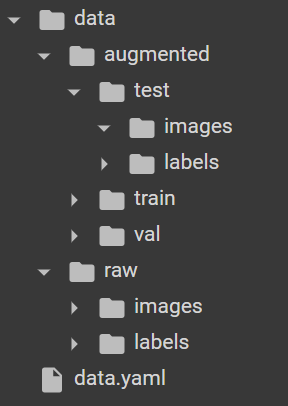)

In [9]:
train_test_val_split = (0.7, 0.2, 0.1)
out_folder = "data/augmented"
in_folder = "data/raw"

img_names, label_names = get_file_names(in_folder)
train_images, train_labels, val_images, val_labels, test_images, test_labels = split_file_names(img_names,label_names,train_test_val_split)
do_augs_and_export(train_images,train_labels,in_folder,out_folder + "/train")
do_augs_and_export(val_images,val_labels,in_folder,out_folder + "/val")
do_augs_and_export(test_images,test_labels,in_folder,out_folder + "/test")


Load in all files from /raw folder, pass list of images sequentially through each augmentation function, then output final images to /augmented folder

In [ ]:
# train_test_val_split = (0.7, 0.2, 0.1)
# out_folder = "data/augmented"
# in_folder = "data/raw"

# print("Loading data...")
# data = loadInputData(in_folder)

#FOR TESTING uncomment to visualize individual augmentations
#visualizeAugmentation(data[0][0], colorAugment)
#exit()

In [ ]:
# def do_all_augs(stuff):
#     stuff = colorAugment(stuff)
#     stuff = brightnessAugment(stuff)
#     sutff = contrastAugment(stuff)
#     return blurAugment(stuff)

# train, test, val = splitData(data, train_test_val_split)

# # print("Augmenting color...")
# data = colorAugment(data) # times 3
# print("Augmenting brightness...")
# data = brightnessAugment(data) # times 3
# print("Augmenting contrast...")
# data = contrastAugment(data) # times 2
# #print("Augmenting blur...")
# #data = blurAugment(data) # times 2
# print("Splitting data...")

# train = do_all_augs(train)
# test = do_all_augs(test)
# val = do_all_augs(val)

# print("Exporting training data...")
# sendToFolders(train, out_folder + "/train")
# print("Exporting test data...")
# sendToFolders(test, out_folder + "/test")
# print("Exporting val data...")
# sendToFolders(val, out_folder + "/val")
# print("Done. Final number of samples: " + str(len(data)))

# Train YOLO model with augmented data

In [10]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
#Ensure this prints true and a number > 0, if not make sure you set hardware accelerator to GPU in Edit > Notebook Settings > Hardware Accelerator
# !rm -r runs/detect/train*
!mkdir runs
!mkdir runs/detect
!mkdir runs/detect/train

True
1


In [12]:
#UNCOMMENT TO START FROM SCRATCH
torch.cuda.empty_cache()
model = YOLO("yolov8n.pt")  # load a pretrained model
#model = YOLO("runs/detect/train11/weights/last.pt")
# CONTINUE TRAINING
#model = YOLO("current_model.pt") #load a previous model in case training interrupts

# Train the model in increments
epoch_increments = 50
# while True:
model.train(data="data.yaml", epochs=epoch_increments, device=0, batch=16, degrees=360, flipud=0.5, fliplr=0.5, perspective=0.001, translate=0.1, scale=0.3,mosaic=0.5,mixup=0.5, pretrained=True, task='detect')  # train the model
model.val()
#shutil.copyfile("runs/detect/train" + str(i) + "/weights/best.pt", "/content/drive/My Drive/AUV_model_" + str(i) + ".pt")


Ultralytics YOLOv8.0.207 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=Fa

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79137b596b90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [15]:
def visualizeBbox(img, bbox, class_name, thickness=2, fontSize=0.5):
    #get xmin, xmax, ymin, ymax from bbox
    BOX_COLOR=(0,255,0)
    TEXT_COLOR = (0,0,0)
    x_center, y_center, w, h = bbox
    x_min = x_center - w/2
    y_min = y_center - h/2
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    #draw bounding box on image
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=BOX_COLOR, thickness=thickness)
    #get size of class name text
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, fontSize, 1)
    #draw box around class name label on image
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    #put class name text in the box we drew
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=fontSize,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img

# Predict on image with model

In [16]:
img_path = "data/augmented/test/images/img105.png"
img = cv2.imread(img_path)
# Load a model
model = YOLO("runs/detect/train3/weights/best.pt")  # load a model
# Use the model
pred = model(img)
for results in pred:
    box = results.boxes
    print(box)
    print("\nprediction:" + str(list(box.xywh)))
    print("\nprediction:" + str(list(box.conf)))
    print("\nprediction:" + str(list(box.cls)))

points = box.xywh.tolist()[0]
boxed = visualizeBbox(img,points,"gate")
cv2.imwrite("test.png",boxed)


0: 384x640 1 Earth Symbol, 1 Octagon Table, 101.6ms
Speed: 3.7ms preprocess, 101.6ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([5., 2.], device='cuda:0')
conf: tensor([0.8556, 0.3383], device='cuda:0')
data: tensor([[1.8616e+02, 0.0000e+00, 8.5335e+02, 5.4959e+02, 8.5564e-01, 5.0000e+00],
        [4.5889e+01, 8.6485e+01, 6.0198e+02, 4.4967e+02, 3.3832e-01, 2.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (561, 994)
shape: torch.Size([2, 6])
xywh: tensor([[519.7531, 274.7956, 667.1948, 549.5912],
        [323.9359, 268.0766, 556.0939, 363.1833]], device='cuda:0')
xywhn: tensor([[0.5229, 0.4898, 0.6712, 0.9797],
        [0.3259, 0.4779, 0.5595, 0.6474]], device='cuda:0')
xyxy: tensor([[186.1556,   0.0000, 853.3505, 549.5912],
        [ 45.8889,  86.4849, 601.9828, 449.6682]], device='cuda:0')
xyxyn: tensor([[0.1873, 0.0000, 0.8585, 0.9797],
        [0.0462, 0.1542, 0.6056, 0.8015]], device='cuda:0')

prediction:[tensor([519.7531, 274.7956, 667.1948, 549.5912], device='cuda:0'), tensor([323.9359, 268.0766, 556.0939, 363.1833]

True

In [17]:
model.export()

Ultralytics YOLOv8.0.207 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/train3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (6.0 MB)

TorchScript: starting export with torch 2.1.0+cu118...
TorchScript: export success ✅ 3.6s, saved as 'runs/detect/train3/weights/best.torchscript' (11.9 MB)

Export complete (6.9s)
Results saved to /content/runs/detect/train3/weights
Predict:         yolo predict task=detect model=runs/detect/train3/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train3/weights/best.torchscript imgsz=640 data=data.yaml  
Visualize:       https://netron.app


'runs/detect/train3/weights/best.torchscript'